In [1]:
import sys
import inspect
import os
import numpy as np
import pandas as pd
import math
import bisect
import matplotlib.pyplot as plt
import seaborn as sb
import ast
from scipy import stats as st

In [65]:
# Get participant ids
participant_data = pd.read_csv("./data/participant_data.csv")
p_ids = list(participant_data["id"])
p_ids.sort()

# Read in data
main_trials = [pd.read_csv(f"./data/{p_id}/main/trials.csv") for p_id in p_ids]
params = [pd.read_csv(f"./data/{p_id}/params.csv") for p_id in p_ids]

# Filter data
main_trials = [trials[trials['time_score'] == 1000] for trials in main_trials]  # Only trials with good timing

## Burst force und subjective answer

In [66]:
korr_force_subj = pd.DataFrame(columns=["data"])
korr_force_subj["data"] = ["Korr zwischen |burst_force| und subj_answer", "P-Wert 1", "Permutation test p-Wert", "Korr zwischen burst_time und subj_answer", "P-Wert 2"]

print("Calculating: ", end='')
for p_id, trials in zip(p_ids, main_trials):
    print(p_id, end=", ")
    
    trials = trials[trials['subj_answer'].notnull()].copy()  # Only trials where question was asked
    trials['trial_burst_force'] = trials['trial_burst_force'].abs()  # Look at |burst_force|

    # Korrelation zwischen burst force und subjective answer berechnen
    res_force_answer_spearmanr = st.spearmanr(trials['trial_burst_force'], trials['subj_answer'])

    # Permutation test for p because of small batch size
    def statistic(x):  # permute only `x`
        return st.spearmanr(x, trials['subj_answer']).statistic
    res_exact = st.permutation_test((trials['trial_burst_force'],), statistic, permutation_type='pairings')

    res_time_answer_spearmanr = st.spearmanr(trials['trial_burst_time'], trials['subj_answer'])
    
    korr_force_subj[str(p_id)] = list(res_force_answer_spearmanr) + [res_exact.pvalue] + list(res_time_answer_spearmanr)
    
display(korr_force_subj)

Calculating: 41, 43, 64, 

,data,41,43,64
0,Korr zwischen |burst_force| und subj_answer,0.228870,-0.040585,4.317251e-01
1,P-Wert 1,0.001492,0.597084,4.497997e-10
2,Permutation test p-Wert,0.001400,0.585800,2.000000e-04
3,Korr zwischen burst_time und subj_answer,0.339894,-0.019233,3.040286e-01
4,P-Wert 2,0.000002,0.802262,1.904235e-05


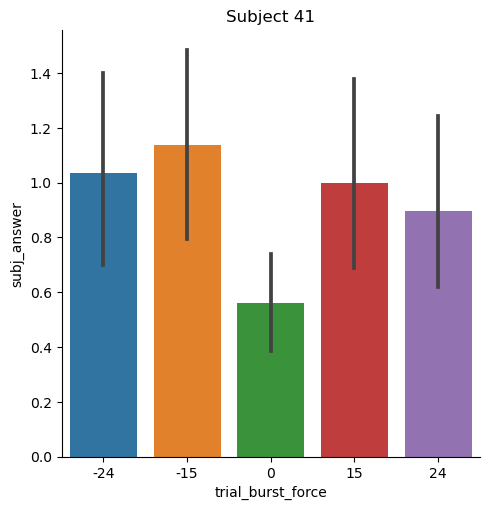

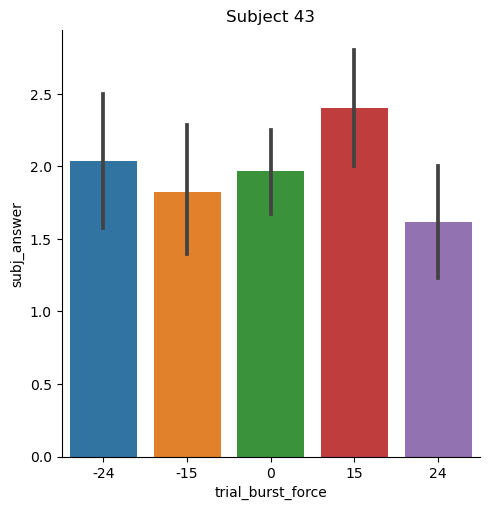

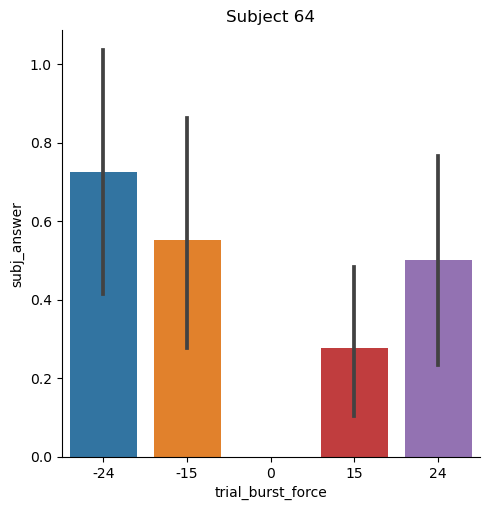

In [67]:
# Histogramme
for p_id, trials in zip(p_ids, main_trials):
    trials = trials[trials['subj_answer'].notnull()].copy()  # Only trials where question was asked
    #trials['trial_burst_force'] = trials['trial_burst_force'].abs()  # Look at |burst_force|
    sb.catplot(data=trials, kind="bar", x="trial_burst_force", y="subj_answer")
    plt.title(f"Subject {p_id}")
    
# COM: there is some variation for problems like this. (log-odds stuffs)

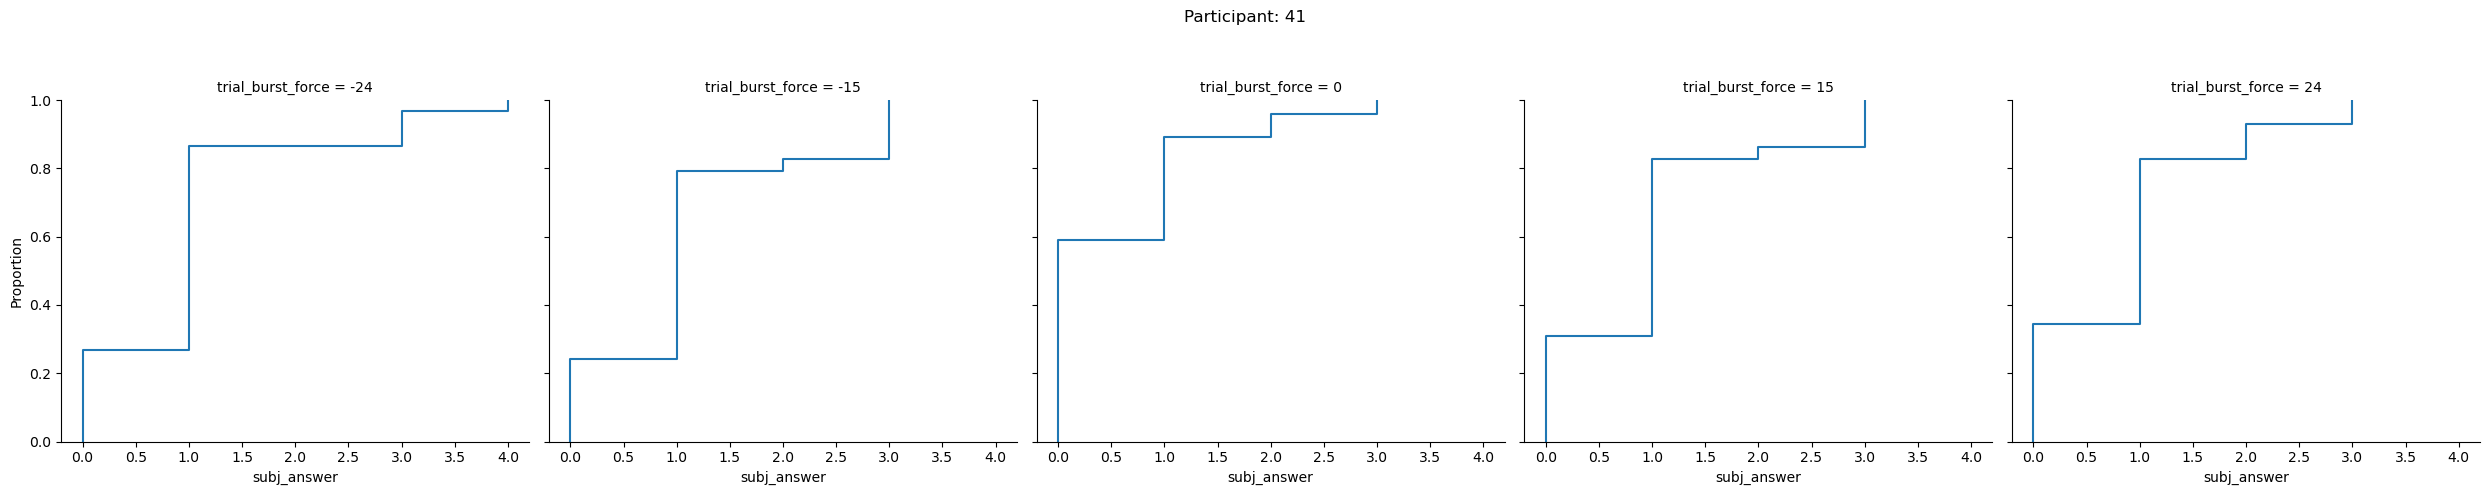

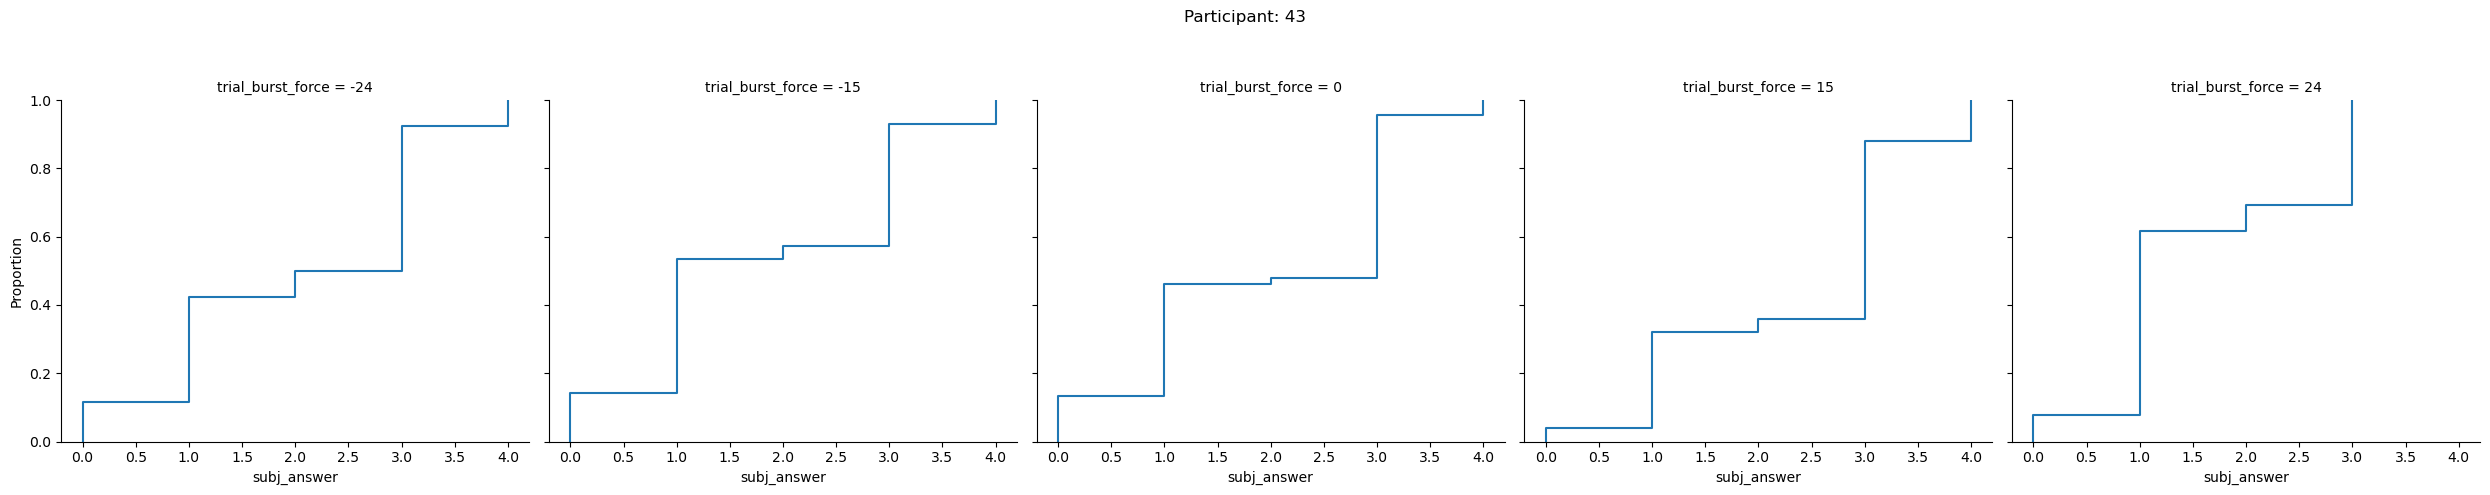

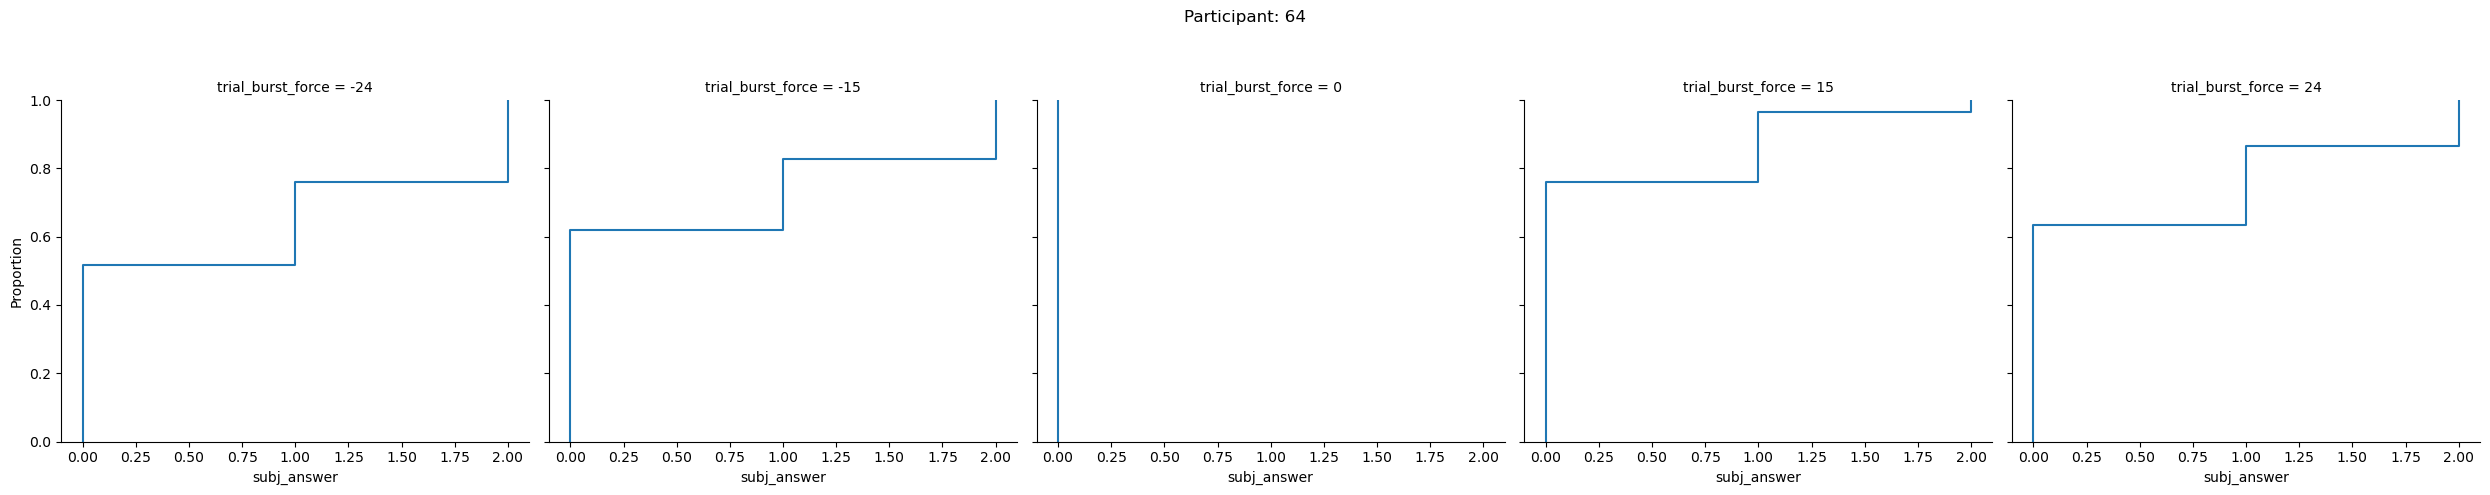

In [68]:
for p_id, trials in zip(p_ids, main_trials):
    plot = sb.displot(data=trials, x="subj_answer", col="trial_burst_force", kind="ecdf")
    plot.fig.subplots_adjust(top=.8)
    plot.fig.suptitle(f"Participant: {p_id}")
# COM: may be put into a test straight away

## Trajectory

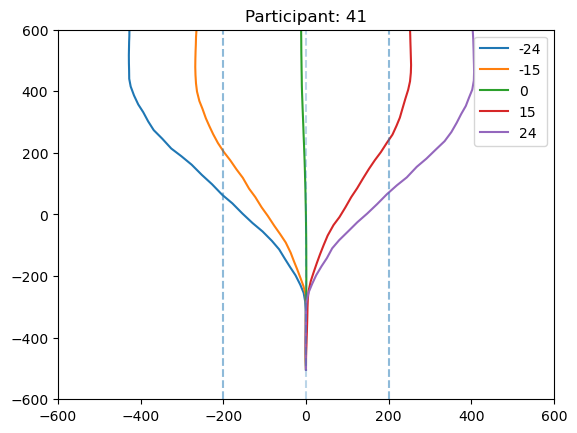

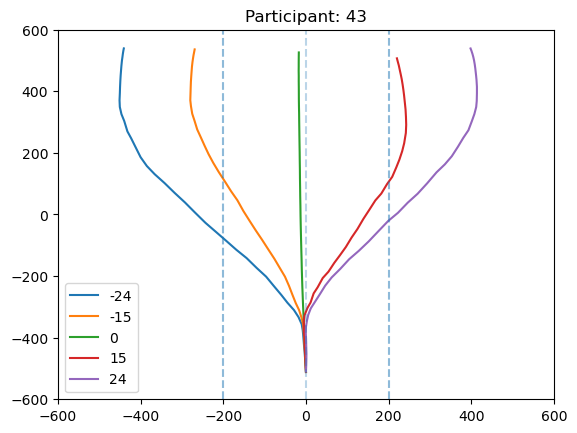

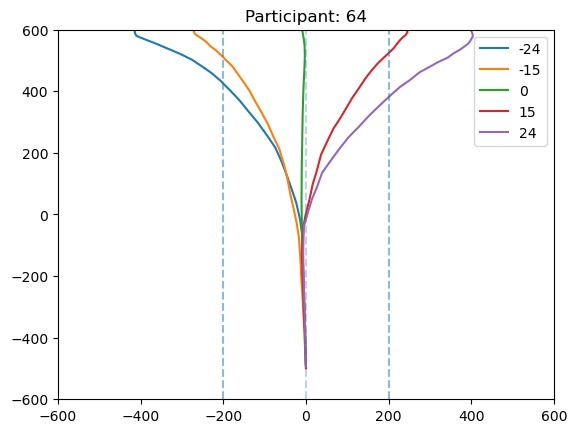

In [69]:
# Virtual mouse pos
for p_id, trials in zip(p_ids, main_trials):
    forces = trials["trial_burst_force"].unique()
    forces.sort()
    for f in forces:
        trials_force = trials[trials["trial_burst_force"] == f]
        paths_x = np.array([np.zeros(48)])
        paths_y = np.array([np.zeros(48)])
        for _,g in trials_force.iterrows():
            p = np.stack(np.load(f"./data/{p_id}/main/b{g['block_nr']}_t{g['trial_nr']}_fm.npy", allow_pickle=True)[2])
            if len(p) >= 48:
                paths_x = np.append(paths_x, [p[:48,0]], axis=0)
                paths_y = np.append(paths_y, [p[:48,1]], axis=0)

        paths_x = paths_x[1:]
        paths_y = paths_y[1:]
        avg_path_x = np.average(paths_x, axis=0)
        avg_path_y = np.average(paths_y, axis=0)
        avg_path_x = avg_path_x - avg_path_x[0]
        plt.plot(avg_path_x, avg_path_y, label=f)

    plt.ylim(-600, 600)
    plt.xlim(-600,600)
    plt.axvline(200, ls='--', alpha=0.5)
    plt.axvline(-200, ls='--', alpha=0.5)
    plt.axvline(0, ls='--', alpha=0.3)
    plt.title(f"Participant: {p_id}")
    plt.legend()
    plt.show()

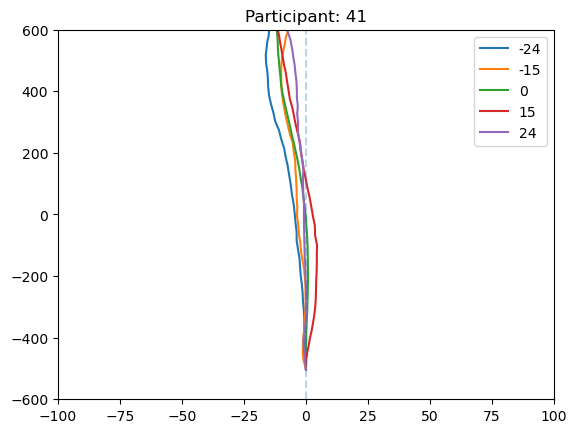

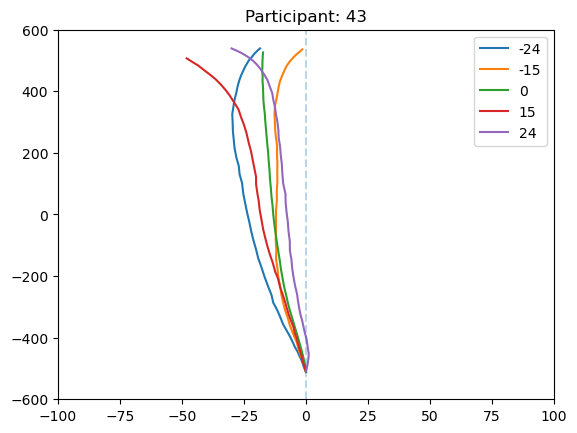

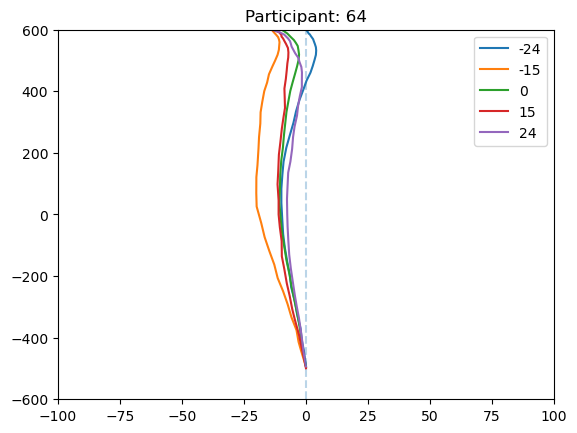

In [70]:
# Actual mouse pos
for p_id, trials in zip(p_ids, main_trials):
    forces = trials["trial_burst_force"].unique()
    forces.sort()
    for f in forces:
        trials_force = trials[trials["trial_burst_force"] == f]
        paths_x = np.array([np.zeros(48)])
        paths_y = np.array([np.zeros(48)])
        for _,g in trials_force.iterrows():
            p = np.stack(np.load(f"./data/{p_id}/main/b{g['block_nr']}_t{g['trial_nr']}_fm.npy", allow_pickle=True)[0])
            if len(p) >= 48:
                paths_x = np.append(paths_x, [p[:48,0]], axis=0)
                paths_y = np.append(paths_y, [p[:48,1]], axis=0)

        paths_x = paths_x[1:]
        paths_y = paths_y[1:]
        avg_path_x = np.average(paths_x, axis=0)
        avg_path_y = np.average(paths_y, axis=0)
        avg_path_x = avg_path_x - avg_path_x[0]
        plt.plot(avg_path_x, avg_path_y, label=f)

    plt.ylim(-600, 600)
    plt.xlim(-100,100)
    plt.axvline(0, ls='--', alpha=0.3)
    plt.title(f"Participant: {p_id}")
    plt.legend()
    plt.show()
    


## PR and Force

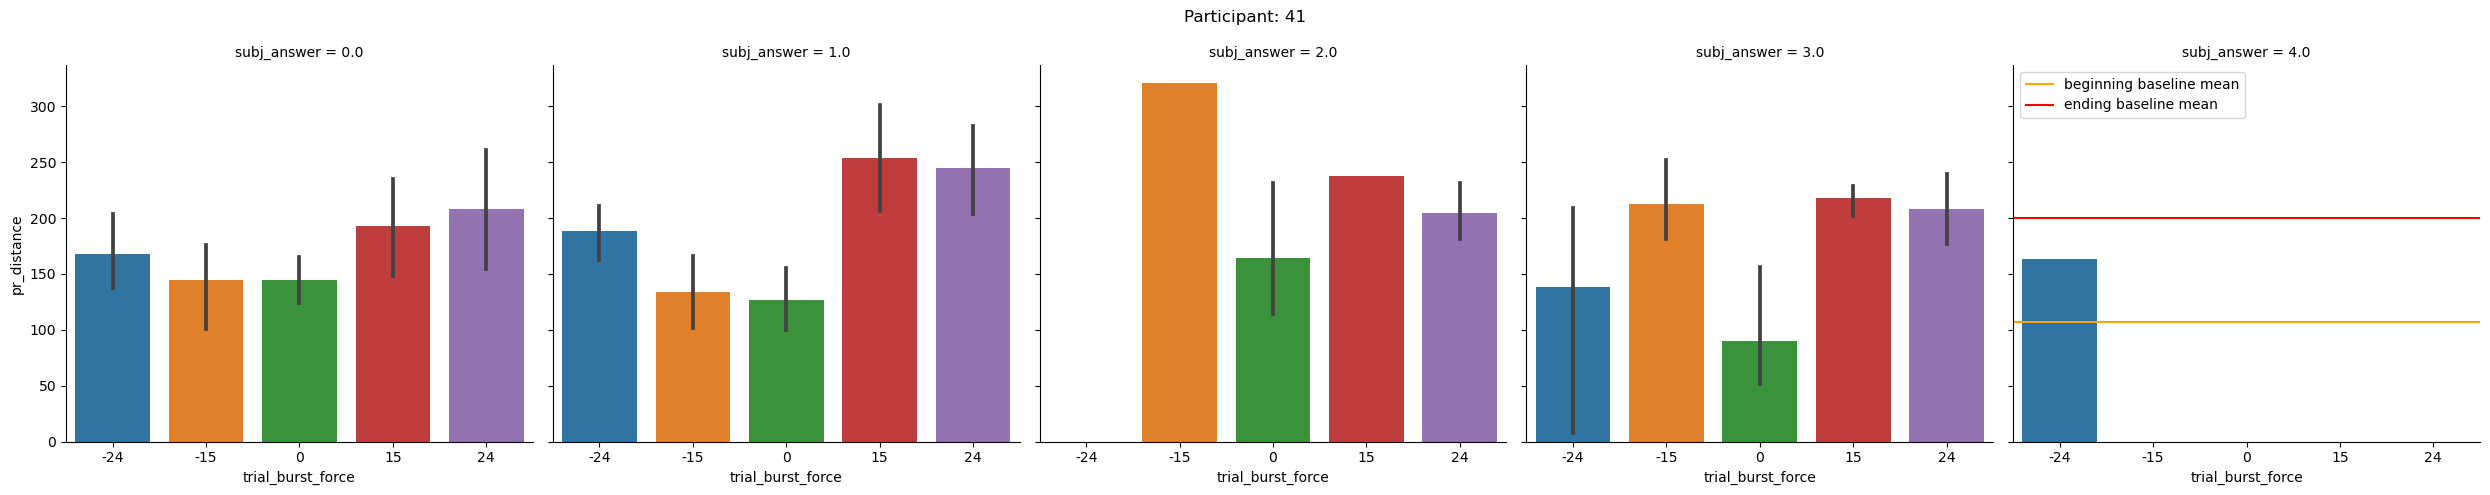

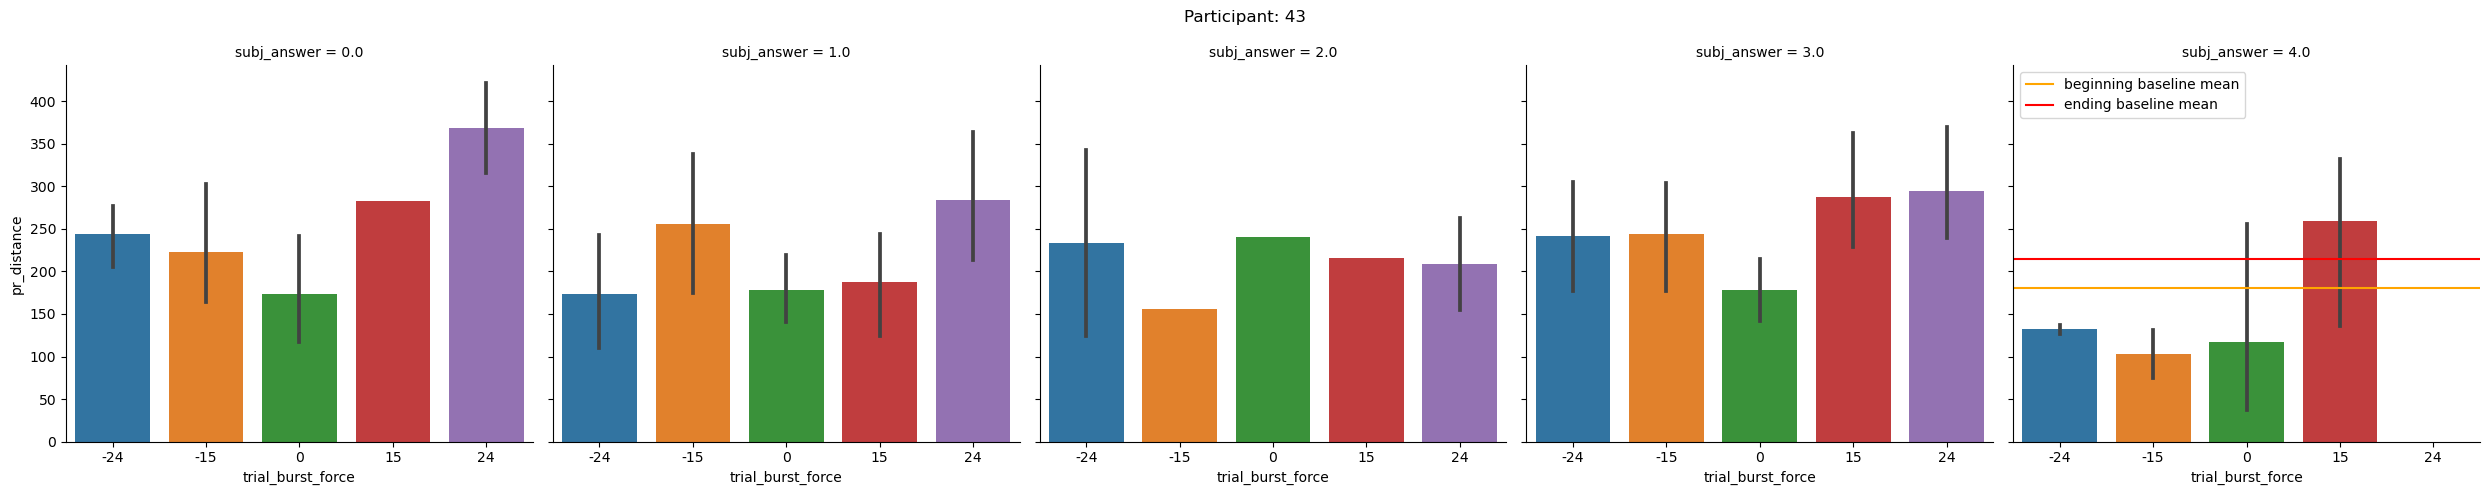

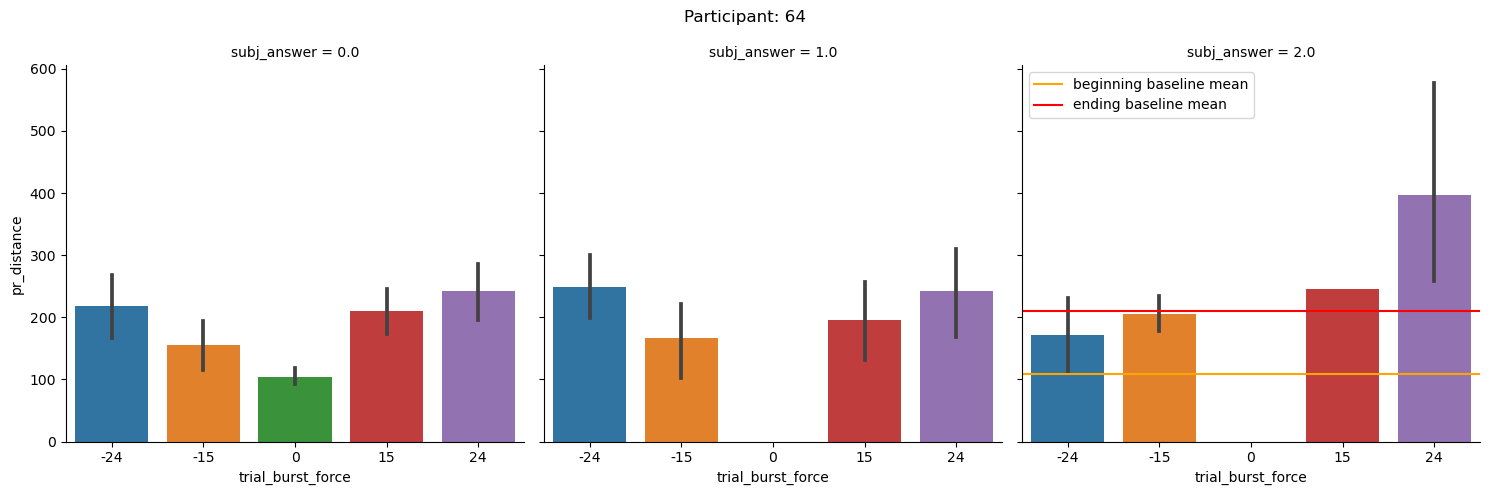

In [71]:
# Vergleichen von pr_dist normal mit pr_dist unter force
for p_id, trials in zip(p_ids, main_trials):
    trials = trials[trials['subj_answer'].notnull()].copy()  # Only trials where question was asked

    plot = sb.catplot(data=trials, kind="bar", x="trial_burst_force", y="pr_distance", col="subj_answer")

    base1 = pd.read_csv(f"./data/{p_id}/begin/trials.csv")
    base1_mean = base1["pr_distance"].mean()
    base2 = pd.read_csv(f"./data/{p_id}/end/trials.csv")
    base2_mean = base2["pr_distance"].mean()

    plt.axhline(y=base1_mean, color="orange", label="beginning baseline mean")
    plt.axhline(y=base2_mean, color="red", label="ending baseline mean")
    
    plot.fig.subplots_adjust(top=.87)
    plot.fig.suptitle(f"Participant: {p_id}")
    plt.legend()

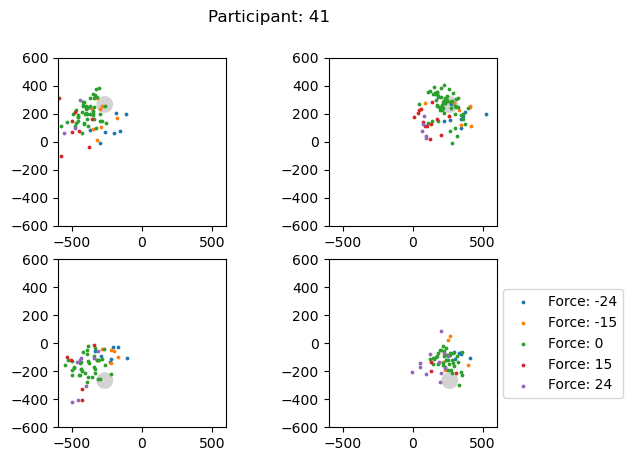

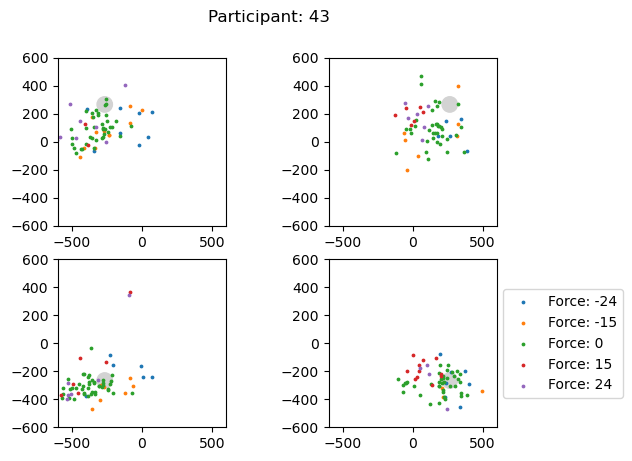

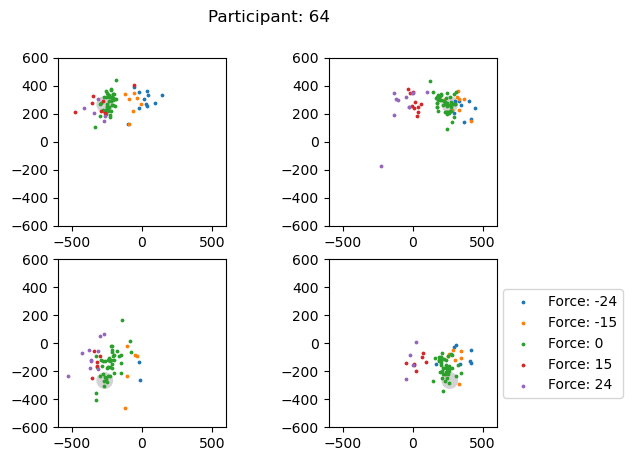

In [83]:
target_poss = ['[-266, 266]', '[266, 266]', '[-266, -266]', '[266, -266]']
idxs = [(0,0), (0,1), (1,0), (1,1)]

for p_id, trials in zip(p_ids, main_trials):
    fig, ax = plt.subplots(2,2)
    for idx, t in zip(idxs, target_poss):
        data = trials[trials["pr_target"] == t].sort_values("trial_burst_force") 
        cc = plt.Circle(ast.literal_eval(t), 55, color='lightgray') 
        ax[idx[0]][idx[1]].set(xlim=(-600,600), ylim=(-600,600), aspect=1)
        ax[idx[0]][idx[1]].add_artist(cc)
        for f in data["trial_burst_force"].unique():
            ax[idx[0]][idx[1]].scatter(data[data["trial_burst_force"] == f]["pr_mouse_pos_x"], data[data["trial_burst_force"] == f]["pr_mouse_pos_y"], s=3, label=f"Force: {f}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.suptitle(f"Participant: {p_id}")
    plt.show()
# COM: Look at corr between last virtual pos and the click pos

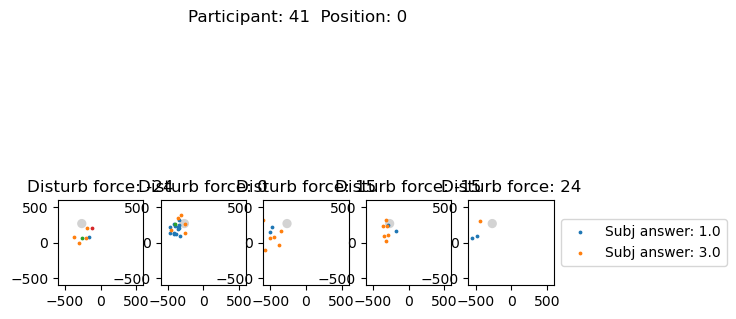

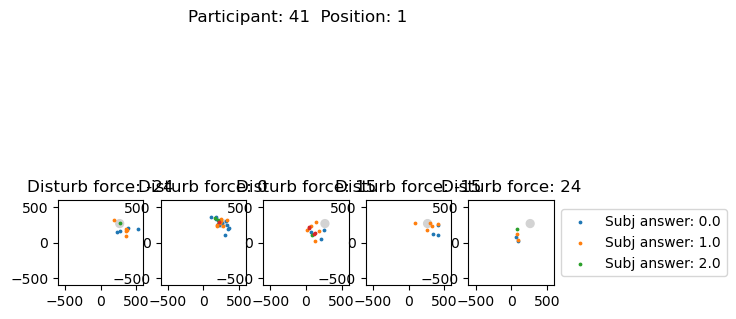

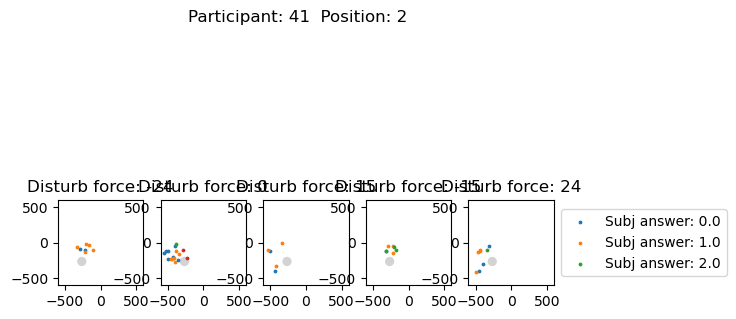

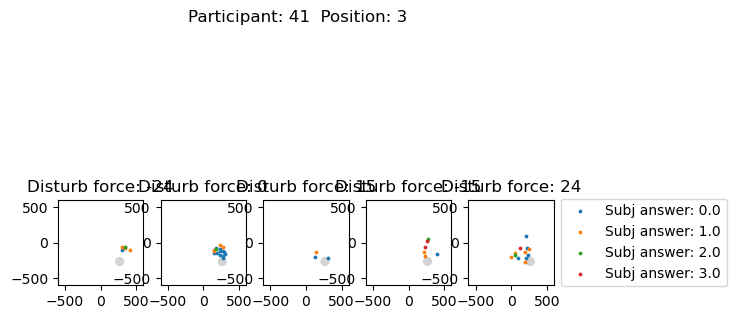

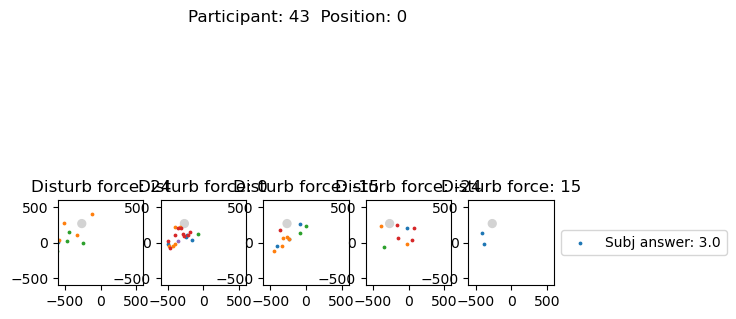

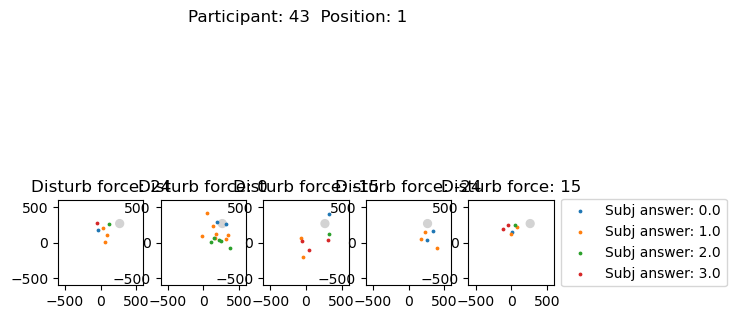

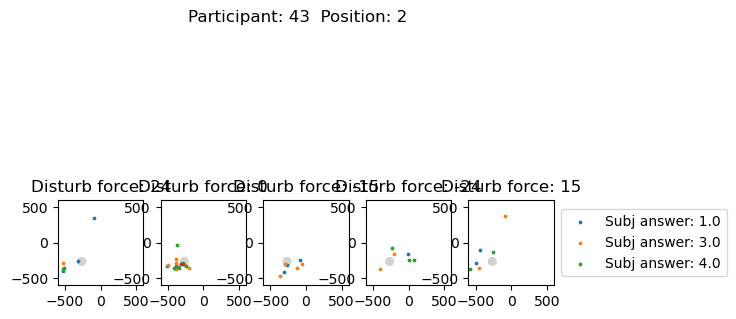

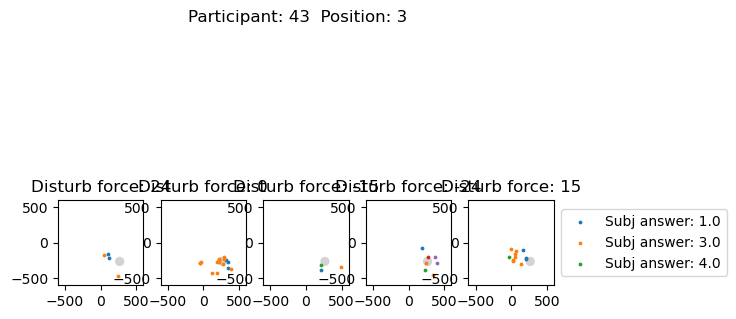

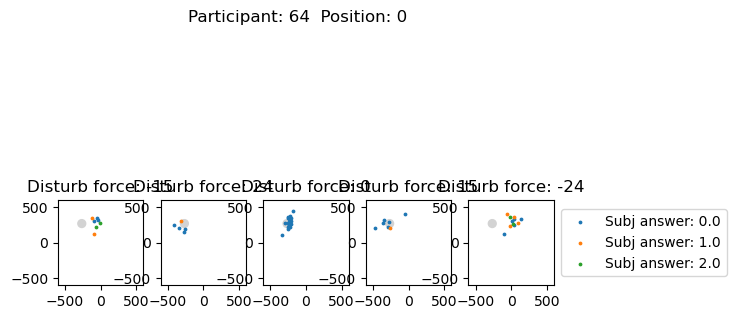

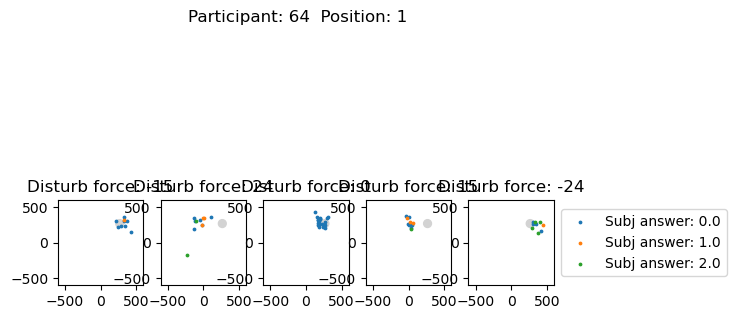

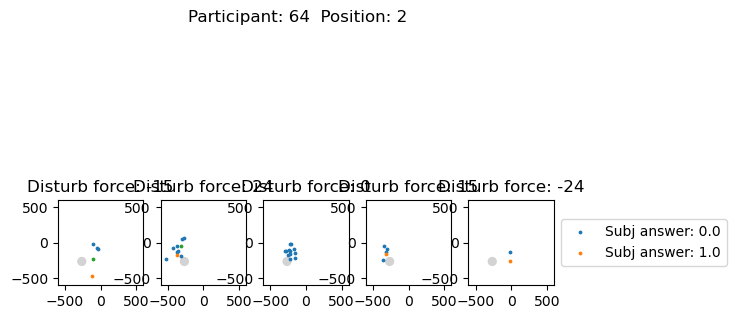

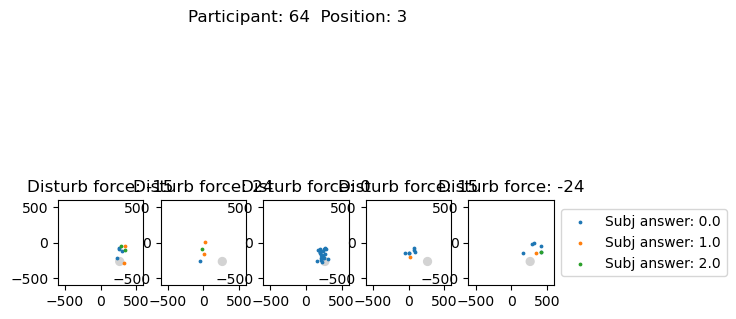

In [88]:
#sb.displot(data=trials, x="pr_mouse_pos_x", y="pr_mouse_pos_y", col="trial_burst_force", hue="pr_target_x")
target_poss = ['[-266, 266]', '[266, 266]', '[-266, -266]', '[266, -266]']
idxs = [(0,0), (0,1), (1,0), (1,1)]

for p_id, trials in zip(p_ids, main_trials):
    for k, target_pos in enumerate(target_poss):
        fig, ax = plt.subplots(1,5)
        data_0 = trials[(trials["pr_target"] == target_pos)].sort_values("subj_answer")
        for i, f in enumerate(trials["trial_burst_force"].unique()):
            data = data_0[data_0["trial_burst_force"] == f]
            cc = plt.Circle(ast.literal_eval(target_pos), 55, color='lightgray')
            ax[i].set(xlim=(-600,600), ylim=(-600,600), aspect=1)
            ax[i].add_artist(cc)
            ax[i].set_title(f"Disturb force: {f}")
            for s in data["subj_answer"].unique():
                ax[i].scatter(data[data["subj_answer"] == s]["pr_mouse_pos_x"], data[data["subj_answer"] == s]["pr_mouse_pos_y"], s=3, label=f"Subj answer: {s}")
        fig.suptitle(f"Participant: {p_id}  Position: {k}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

## PR over time

[(0.0, 400.0), Text(0.5, 1.0, 'Click-Task during training phase2')]

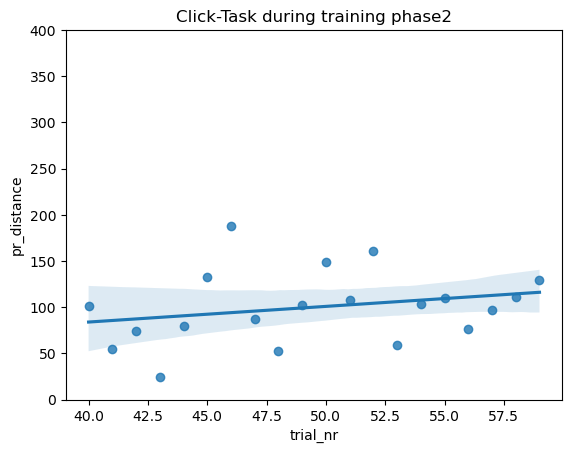

In [26]:
# PR during training(phase2)
trials_t2 = pd.read_csv("./data/celine/train2/trials.csv")
d = sb.regplot(data=trials_t2, x='trial_nr', y="pr_distance")#, kind="line")
d.set(ylim=(0,400), title="Click-Task during training phase2")

[(0.0, 400.0), Text(0.5, 1.0, 'Click-task baseline after task')]

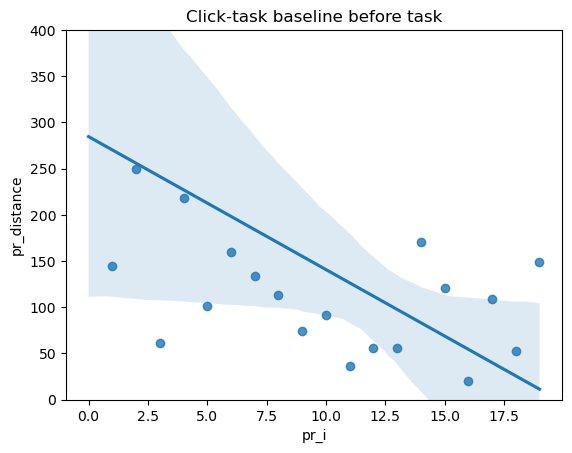

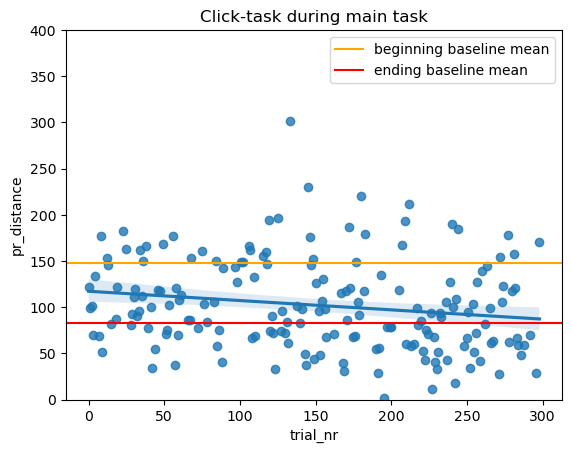

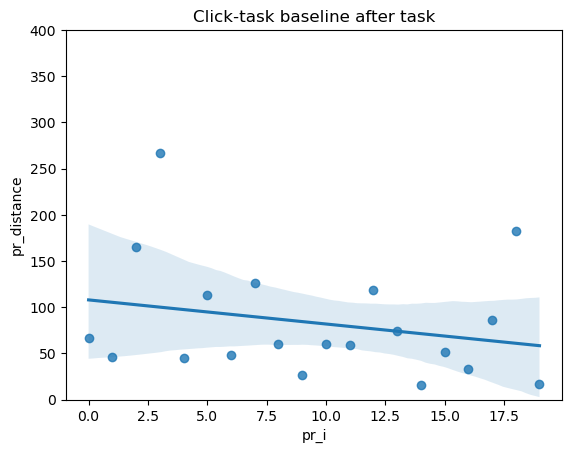

In [25]:
plt.figure(0)
a = sb.regplot(data=base1, x='pr_i', y="pr_distance")#, kind="line")
a.set(ylim=(0,400), title="Click-task baseline before task")
plt.figure(2)
d = sb.regplot(data=trials[trials["trial_burst_force"] == 0], x='trial_nr', y="pr_distance")#, kind="line")
d.set(ylim=(0,400), title="Click-task during main task")
plt.axhline(y=base1_mean, color="orange", label="beginning baseline mean")
plt.axhline(y=base2_mean, color="red", label="ending baseline mean")
plt.legend()
plt.figure(1)
b = sb.regplot(data=base2, x='pr_i', y="pr_distance")#, kind="line")
b.set(ylim=(0,400), title="Click-task baseline after task")

## Questionnaire and subj answer

In [17]:
# res_force_answer_spearmanr.statistic?
avg_subj_answer = trials[trials['trial_burst_force'] != 0]['subj_answer'].mean()
avg_subj_answer_no_burst = trials[trials['trial_burst_force'] == 0]['subj_answer'].mean()
print(f"Normalized average subjective answer when no distortion happened: {avg_subj_answer_no_burst/4}")
print(f"Normalized average subjective answer when a distortion happened: {avg_subj_answer/4}")

quest2 = pd.read_csv("./data/celine/2_questionnaire.csv")
sss, spq = quest2[1:10], quest2[11:]
avg_sss = sss['response'].mean()
avg_spq = spq['response'].mean()
print(f"Normalized average susceptibility score: {avg_sss/4}")
print(f"Normalized average SPQ score: {avg_spq/3}")
print(f"Combined normalized average questionnaire score: {(avg_sss/4 + avg_spq/3)/2}")

# TODO: correlation over all participants

Normalized average subjective answer when no distortion happened: 0.21621621621621623
Normalized average subjective answer when a distortion happened: 0.4041666666666667
Normalized average susceptibility score: 0.4444444444444444
Normalized average SPQ score: 0.5333333333333333
Combined normalized average questionnaire score: 0.4888888888888889
